In [40]:
import pandas as pd
import datetime as datetime
import pyflux as pf
import matplotlib.pyplot as plt
import numpy as np

#reading into pd dataframe 1000 values
df1=pd.read_csv("dataset-2008.csv",header=3)
df2=pd.read_csv("dataset-2007.csv",header=3)

#renaming column names
df1.columns=["year","month","day","hour","minute","power","w_dir","w_speed","temp","pressure","density"]
df2.columns=["year","month","day","hour","minute","power","w_dir","w_speed","temp","pressure","density"]

#concatinating the data
df=df2.append(df1)

#adding a date-time stamp
df["date_time"]=pd.to_datetime(df[["year","month","day","hour","minute"]])

#describe data
df.head()

,year,month,day,hour,minute,power,w_dir,w_speed,temp,pressure,density,date_time
0,2007,1,1,0,0,0.086,247.697,3.430,266.641,78574.576,0.994,2007-01-01 00:00:00
1,2007,1,1,0,5,0.058,248.791,3.214,266.583,78576.408,0.994,2007-01-01 00:05:00
2,2007,1,1,0,10,0.044,248.666,2.988,266.504,78580.984,0.994,2007-01-01 00:10:00
3,2007,1,1,0,15,0.034,248.354,2.820,266.424,78583.736,0.995,2007-01-01 00:15:00
4,2007,1,1,0,20,0.028,248.596,2.716,266.363,78582.824,0.995,2007-01-01 00:20:00


In [41]:
#a new dataframe which conatins speed and date_time
df1=df[["date_time","w_speed"]]

#change index to time-stamp
df1=df1.set_index('date_time')
df1.index
df1.describe()

,w_speed
count,210240.000000
mean,9.536963
std,5.277508
min,0.042000
25%,5.423000
50%,9.090000
75%,13.131000
max,37.033000


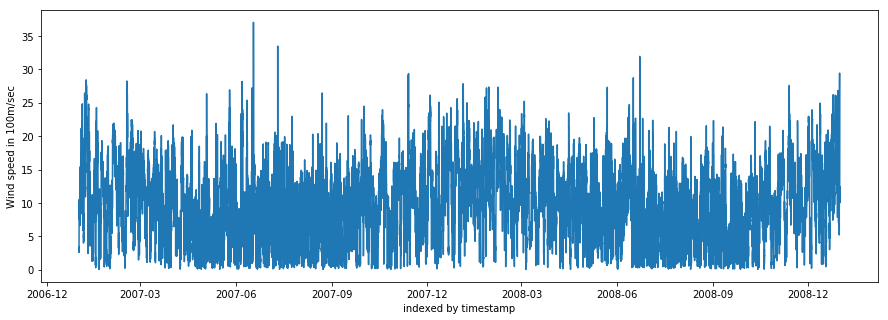

,w_speed
date_time,
2007-01-01 00:00:00,3.430
2007-01-01 00:05:00,3.214
2007-01-01 00:10:00,2.988
2007-01-01 00:15:00,2.820
2007-01-01 00:20:00,2.716


In [42]:
#plotting the data
plt.figure(figsize=(15, 5))
plt.ylabel("Wind speed in 100m/sec")
plt.xlabel("indexed by timestamp")
plt.plot(df1.index,df1)
plt.show()
df1.head()

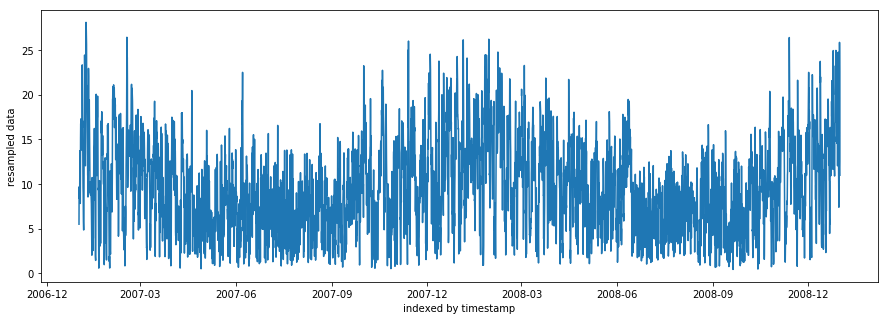

,w_speed
count,5840.000000
mean,9.536963
std,5.043539
min,0.422667
25%,5.637069
50%,8.986000
75%,12.919743
max,28.087222


In [43]:
#from df1 resample wind-speed at hourly basis and find it's mean
#plotting the  resampled data
plt.figure(figsize=(15, 5))
plt.ylabel("resampled data")
plt.xlabel("indexed by timestamp")

#df2 be the new resampled df
df2=pd.DataFrame()
df2["w_speed"]=df1.w_speed.resample('3h').mean()
plt.plot(df2)
plt.show()
df2.column=["w_speed"]
df2.head()
df2.describe()

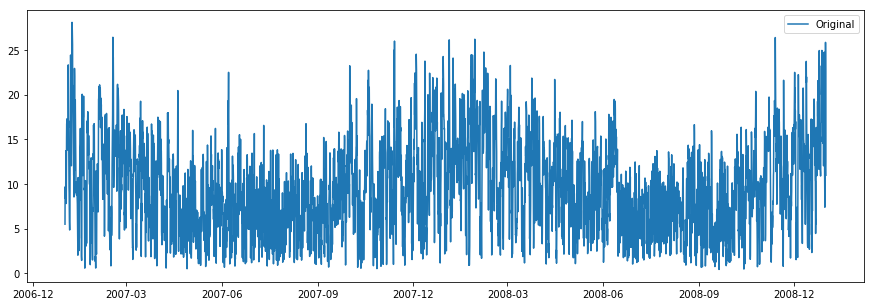

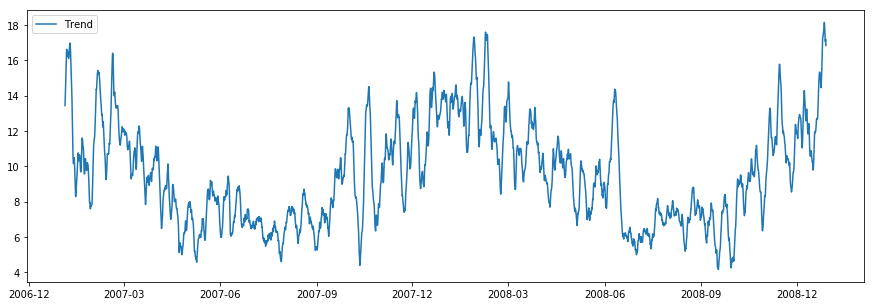

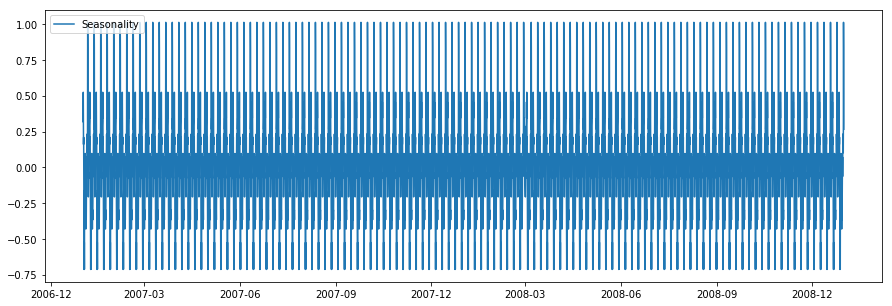

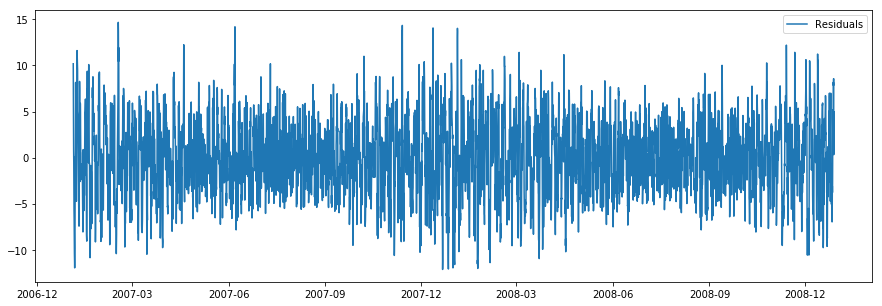

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
#what to give as freq
df2.dropna(inplace=True)
decomposition = seasonal_decompose(df2,freq=50)

#decomposing
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#original data
plt.figure(figsize=(15,5))
plt.plot(df2, label='Original')
plt.legend(loc='best')

#trend
plt.figure(figsize=(15,5))
plt.plot(trend, label='Trend')
plt.legend(loc='best')

#seasonality
plt.figure(figsize=(15,5))
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

#residual
plt.figure(figsize=(15,5))
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [46]:
np_ar=residual
df_final = pd.DataFrame(np_ar,columns=["w_speed"])
df_final.dropna(inplace=True)
df_final.head()

,w_speed
date_time,
2007-01-04 03:00:00,10.183549
2007-01-04 06:00:00,6.299702
2007-01-04 09:00:00,3.394664
2007-01-04 12:00:00,0.696528
2007-01-04 15:00:00,-0.540011


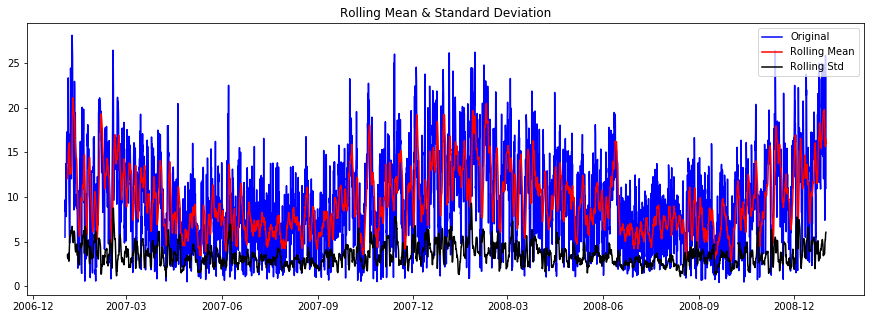

Results of Dickey-Fuller Test:
Test Statistic                -8.426618e+00
p-value                        1.919199e-13
#Lags Used                     3.200000e+01
Number of Observations Used    5.807000e+03
Critical Value (10%)          -2.567035e+00
Critical Value (1%)           -3.431477e+00
Critical Value (5%)           -2.862038e+00
dtype: float64


In [47]:
#testing stationarity using dicky-fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics:
    #moving averaged ,moving sd 
    rolmean = pd.rolling_mean(timeseries, window=20)
    rolstd = pd.rolling_std(timeseries, window=20)

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries["w_speed"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #calling function
test_stationarity(df2)

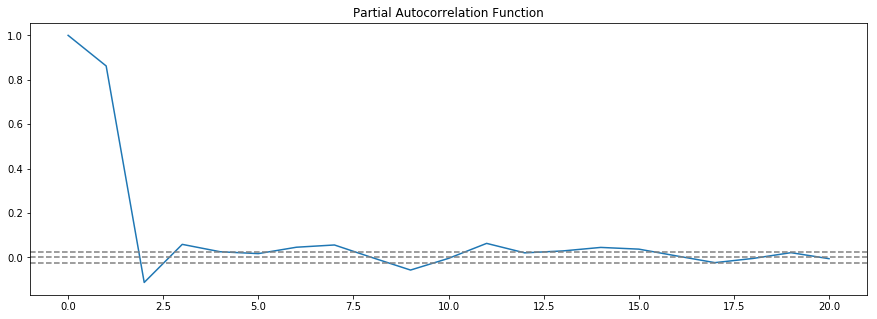

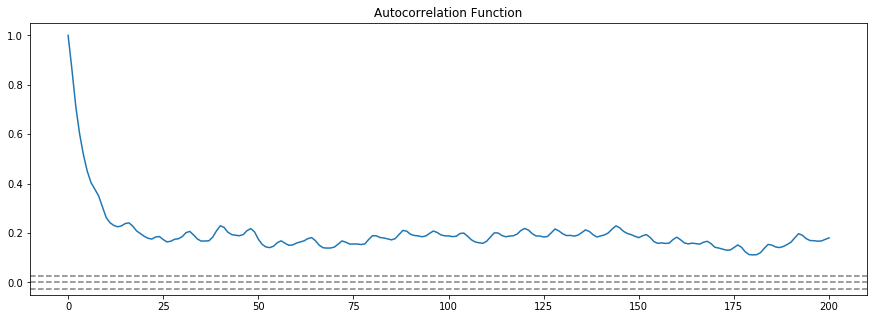

In [50]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df2, nlags=200)
lag_pacf = pacf(df2, nlags=20, method='ols')

#Plot ACF:  
plt.figure(figsize=(15,5))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df2)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

#Plot PACF:
plt.figure(figsize=(15,5))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

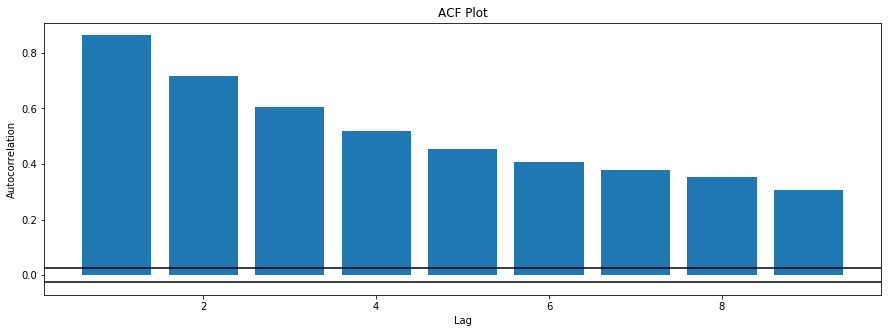

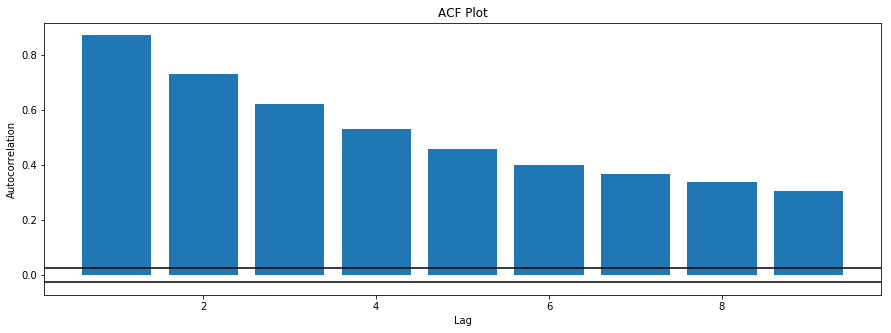

In [52]:
#acf plot :why this behaviour?
pf.acf_plot(df2.values)
pf.acf_plot(np.square(df2.values))